# 3.1 Data Preparation

In [73]:
#setup path
path = 'C:/Users/mark/Documents/GitHub/honours/dev/package/'
import sys; sys.path.append(path)

#standard imports
import numpy as np
import pandas as pd
import datetime
from scipy import stats
from collections import OrderedDict, defaultdict
import math
from datetime import date, timedelta
from itertools import chain, combinations_with_replacement
from functools import partial

#third party imports
from IPython.core.interactiveshell import InteractiveShell
import matplotlib.pyplot as plt
import matplotlib.dates as md
import matplotlib
import matplotlib.ticker as ticker
from matplotlib import rcParams
import seaborn as sns
from sklearn import metrics
from sklearn.preprocessing import Imputer

#local imports
import analysis.dataPreparer as dp
import analysis.autoVC2 as vc

In [74]:
#setup
%matplotlib inline

TINY_SIZE = 12
SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 30

plt.style.use(['seaborn-white', 'seaborn-paper'])
sns.set_palette("colorblind")
rcParams['font.family'] = 'serif' 
rcParams['font.serif'] = 'CMU Serif' 
rcParams['font.weight'] = 'bold'
rcParams['font.size'] = SMALL_SIZE #default font size
rcParams['axes.titlesize'] =SMALL_SIZE   # fontsize of the axes title
rcParams['axes.labelsize'] =MEDIUM_SIZE    # fontsize of the x and y labels
rcParams['xtick.labelsize'] =SMALL_SIZE    # fontsize of the tick labels
rcParams['ytick.labelsize'] =SMALL_SIZE   # fontsize of the tick labels
rcParams['legend.fontsize'] =SMALL_SIZE    # legend fontsize
rcParams['figure.titlesize'] =BIGGER_SIZE  # fontsize of the figure title
rcParams['figure.figsize'] = (8,4)
pd.set_option('precision',3)
outline_bars = dict(linewidth = 1.25, edgecolor = '.15')

save_path = r"C:/Users/mark/Documents/GitHub/honours/submissions/thesis-original/figures/design/"
evaluation_path = r"C:/Users/mark/Documents/GitHub/honours/submissions/thesis-original/figures/evaluation/"

In [75]:
def auto_label(ax, fmt='{:,.0f}'):
    ymax_old = ax.get_ylim()[1]
    ax.set_ylim(ymax= ax.get_ylim()[1] * 1.1)
    for p in ax.patches:
        height = p.get_height()
        ax.text(
            x=p.get_x()+p.get_width()/2.,
            y=np.nanmax([height,0]) + ymax_old * 0.02,
            s=fmt.format(np.nanmax([height,0])),
            ha="center")
    ax.yaxis.set_ticks([])

In [76]:
def add_vertical_line(ax, value, label, color, linestyle="dashed"):
    ax.axvline(value, linestyle=linestyle, color=color)
    x_bounds = ax.get_xlim()
    xy_pos = (((value-x_bounds[0])/(x_bounds[1]-x_bounds[0])),1.01)
    ax.annotate(s=label, xy =xy_pos, xycoords='axes fraction', verticalalignment='right', horizontalalignment='right bottom', color=color)

In [77]:
def add_horizontal_line(ax, value, label, color, linestyle="dashed"):
    ax.axhline(value, linestyle=linestyle, color=color)
    y_bounds = ax.get_ylim()
    xy_pos = (1.01,((value-y_bounds[0])/(y_bounds[1]-y_bounds[0])))
    ax.annotate(s=label, xy =xy_pos, xycoords='axes fraction', verticalalignment='right', horizontalalignment='right bottom', color=color)

In [78]:
def add_boxplot_labels(ax, labels, color="black"):
    y_bounds = ax.get_ylim()
    for value, label in enumerate(labels):
        xy_pos = (1.01,((value-y_bounds[0] + 0.15)/(y_bounds[1]-y_bounds[0])))
        ax.annotate(s=label, xy =xy_pos, size=TINY_SIZE, xycoords='axes fraction', verticalalignment='right', horizontalalignment='right bottom', color=color)

In [79]:
def get_results(build, stage):
    
    def split_date(x):
        return date(*map(int, x.split("-")))
    
    df = pd.read_pickle(r"C:\Users\mark\Documents\GitHub\honours\dev\package\analysis\output\autoVC\{}\{}\log_results.pkl".format(build, stage))
    df = df.reset_index()
    try: df["Time"] = pd.to_numeric(df["mean_fit_time"],errors="coerce")
    except: print("Error: Time")
    try: df["Imputer"] = df["param_imputer__strategy"].map({"most_frequent": "Mode", "median": "Median", "mean": "Mean"})
    except: print("Error: Imputer")
    try: df["Transformer"] = df["param_transformer__func"].astype(str).map({"None":"None","<ufunc 'sqrt'>":"SQRT","<ufunc 'log1p'>": "Log1P"})
    except: print("Error: Transformer")
    try: df["Scaler"] = df['param_scaler'].apply(lambda x: str(x).split("(")[0])
    except: print("Error: Scaler")
    try: 
        df["param_extractor__n_components_bin_20"] = df["param_extractor__n_components"] // 20
        df["Extractor"]=df['param_extractor__n_components_bin_20'].map({0 : "1-20", 1 : "21-40", 2: "41-60",3: "61-80", 4: "81-100"})
    except: print("Error: Extractor")
    try: 
        df["Classifier"] = df["Classifier"].apply(lambda x: str(x).split("(")[0])
        df["Classifier"]=df['Classifier'].map({"LogisticRegression": "Logistic Regression", "RandomForestClassifier":"Random Forest", "DecisionTreeClassifier": "Decision Tree", "GaussianNB": "Naive Bayes", "MLPClassifier": "Artificial Neural Network", "KNeighborsClassifier": "K-Nearest Neighbors", "CalibratedClassifierCV": "Support Vector Machine"})
    except: print("Error: Classifier")
    try:
        df["label_date"] = df["label_slice"]
        df["label_date_str"] = df["label_date"].astype(str)
        df["feature_date"] = df["feature_slice"]
        df["feature_date_str"] = df["feature_date"].astype(str)
        df["forecast_window"] =  df["label_date"] - df["feature_date"]
        df["forecast_window_months"] = df["forecast_window"].apply(lambda x: x.days // 30)
    except: print("Error: Dates")
    try:
        df["outcome_chance"] = df["outcome_extra_stage_bool"].ix[0].value_counts(normalize=True)[1]
    except: print("Error: Outcome")
    df["Params_str"] = df["Params"].astype(str)
    return df

In [80]:
def create_stages(df, **features):
    df2 = df.copy()
    df2["keys_company_stage"] = "Other"
    df2["keys_company_stage"] = np.where((df2["keys_company_stage"] == "Other") & (df2[features["Closed"]] >= 1), "Closed", df2["keys_company_stage"])
    df2["keys_company_stage"] = np.where((df2["keys_company_stage"] == "Other") & (df2[features["Acquired"]] >= 1), "Acquired", df2["keys_company_stage"])
    df2["keys_company_stage"] = np.where((df2["keys_company_stage"] == "Other") & (df2[features["IPO"]] >= 1), "IPO", df2["keys_company_stage"])
    df2["keys_company_stage_series-d+"] = df2[[features["SeriesD"],features["SeriesE"],features["SeriesF"],features["SeriesG"],features["SeriesH"]]].sum(axis=1)
    df2["keys_company_stage"] = np.where((df2["keys_company_stage"] == "Other") & (df2["keys_company_stage_series-d+"] >= 1), "Series D+", df2["keys_company_stage"])
    df2["keys_company_stage"] = np.where((df2["keys_company_stage"] == "Other") & (df2[features["SeriesC"]] >= 1), "Series C", df2["keys_company_stage"])
    df2["keys_company_stage"] = np.where((df2["keys_company_stage"] == "Other") & (df2[features["SeriesB"]] >= 1), "Series B", df2["keys_company_stage"])
    df2["keys_company_stage"] = np.where((df2["keys_company_stage"] == "Other") & (df2[features["SeriesA"]] >= 1), "Series A", df2["keys_company_stage"])
    df2["keys_company_stage"] = np.where((df2["keys_company_stage"] == "Other") & (df2[features["FundingRaised"]] >= 0), "Seed", df2["keys_company_stage"])
    age_new_cutoff = df2[features["Age"]][df2["keys_company_stage"] == "Seed"].quantile(0.75)
    df2["keys_company_stage"] = np.where((df2["keys_company_stage"] == "Other") & (df2[features["Age"]] <= age_new_cutoff), "Pre-Seed", df2["keys_company_stage"])
    group_stages = {"Other" : "Excluded", "Closed" : "Excluded", "IPO" : "Excluded", "Acquired" : "Excluded", "Pre-Seed" : "Included",
        "Seed" : "Included", "Series A" : "Included", "Series B" : "Included", "Series C" : "Included", "Series D+" : "Included"}
    df2["keys_company_stage_group"] = df2["keys_company_stage"].map(group_stages)
    ordinal_stages = {"Pre-Seed" : 1, "Seed" : 2, "Series A" : 3, "Series B" : 4, "Series C" : 5, "Series D+" : 6,"Other" : np.nan, "Closed" : -1, "IPO" : 7, "Acquired" : 8}
    df2["keys_company_stage_number"] = df2["keys_company_stage"].map(ordinal_stages)
    return df2[["keys_company_stage_group", "keys_company_stage","keys_company_stage_number"]]

In [81]:
def get_feature_values(df, total="Y_Pred"):
    
    def listify(col):
        if type(col.ix[0]) not in [list, np.ndarray, np.array, pd.Series]: 
            return col.apply(lambda x: [x])
        else: return col
    
    def multip(row):
        for col in row.index:
            if col != "total" and type(row[col]) is list and len(row[col]) != row["total"][0]:
                row[col] = row[col] * row["total"][0]
        return row

    df["total"] = df[total].apply(len)
    df = df.apply(listify, axis=0)
    df = df.apply(multip, axis=1)
    df = df.drop("total",axis=1)
    df = df.apply(lambda x: list(chain.from_iterable(x)),axis=0)
    df = df.apply(pd.Series).T
    return df

In [82]:
def feature_function(df, func, group=None):
    df[["Y_Pred","Y_True"]] = df[["Y_Pred","Y_True"]].astype(int)
    if group: return df.groupby(group).apply(lambda x: func(x["Y_True"], x["Y_Pred"]))
    else: return func(df["Y_True"], df["Y_Pred"])

In [83]:
def plot_learning_curve2(df, ax = None, group = None, target = None, multiple=False):

    def prepare_scores(df):
        df = df[["Test_Scores", "Train_Scores", "Train_Sizes"]].apply(lambda x: list(chain.from_iterable(x)))
        df = df.apply(pd.Series).T
        df = df.apply(lambda x: [x.tolist()],axis=0)
        return df
    
    def concat_lists(series):
        return np.array(list(zip(*[element for list_ in [np.array(list(zip(*list_))) for list_ in series] for element in list_])))
    
    def func_across_dims(l, func):
        output = []
        for suba in l:
            output.append(func(suba))
        return np.array(output)
    
    df = prepare_scores(df)
    
    if ax is None: ax = plt.gca()
    
    if group and target:
        test_scores = concat_lists(df.loc[df[group] == target]["Test_Scores"])
        train_scores = concat_lists(df.loc[df[group] == target]["Train_Scores"])
        train_sizes = np.array(df.loc[df[group] == target]["Train_Sizes"]).squeeze()
        ax.set_title("{}".format(target))
    else:
        test_scores = concat_lists(df["Test_Scores"])
        train_scores = concat_lists(df["Train_Scores"])
        train_sizes = np.array(df["Train_Sizes"]).squeeze()
        
    dic_test = defaultdict(partial(np.ndarray, 0))
    dic_train = defaultdict(partial(np.ndarray, 0))
    scores = list(zip(test_scores, train_scores))
    for i, size in enumerate(train_sizes):
        dic_test[size] = np.append(dic_test[size], test_scores[i])
        dic_train[size] = np.append(dic_train[size], train_scores[i])
    train_sizes = []
    test_scores = []
    train_scores = []
    for size in sorted(dic_test):
        train_sizes.append(size)
        test_scores.append(dic_test[size])
        train_scores.append(dic_train[size])

    train_sizes = np.array(train_sizes)
    test_scores = np.array(test_scores)
    train_scores = np.array(train_scores)
        
    train_scores_mean = func_across_dims(train_scores, np.mean)# np.mean(train_scores, axis=1)
    train_scores_std = func_across_dims(train_scores, np.std) #np.std(train_scores,axis=1)
    test_scores_mean = func_across_dims(test_scores, np.mean) #np.mean(test_scores, axis=1)
    test_scores_std = func_across_dims(test_scores, np.std) #np.std(test_scores, axis=1)

    ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="blue")
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="green")
    a, = ax.plot(train_sizes, train_scores_mean, 'o-', color="blue", label="Training score")
    b, = ax.plot(train_sizes, test_scores_mean, 'o-', color="green", label="Cross-validation score")        
    
    ax.grid()
    ax.set_ylim(ymin=0, ymax=1)
    ax.set_xticklabels(["{:,.0f}".format(xtick) for xtick in ax.get_xticks().tolist()])
    if not multiple: plt.legend()
    
    return (a,b)
    

In [84]:
def plot_learning_curve(df, ax = None, group = None, target = None, multiple=False):
    
    def concat_lists(series):
        return np.array(list(zip(*[element for list_ in [np.array(list(zip(*list_))) for list_ in series] for element in list_])))

    if not ax: ax = plt.gca()
    
    if group and target:
        test_scores = concat_lists(df.loc[df[group] == target]["Test_Scores"])
        train_scores = concat_lists(df.loc[df[group] == target]["Train_Scores"])
        train_sizes = df.loc[df[group] == target]["Train_Sizes"].sample(1).squeeze()
        ax.set_title("{}".format(target))
    else:
        test_scores = concat_lists(df["Test_Scores"])
        train_scores = concat_lists(df["Train_Scores"])
        train_sizes = df["Train_Sizes"].sample(1).squeeze()
        print(test_scores, train_scores, train_sizes)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores,axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
            
    ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="blue")
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="green")
    a, = ax.plot(train_sizes, train_scores_mean, 'o-', color="blue", label="Training score")
    b, = ax.plot(train_sizes, test_scores_mean, 'o-', color="green", label="Cross-validation score")        
    
    ax.grid()
    ax.set_ylim(ymin=0, ymax=1)
    ax.set_xticklabels(["{:,.0f}".format(xtick) for xtick in ax.get_xticks().tolist()])
    if not multiple: plt.legend()
    
    return (a,b)
    

In [85]:
def plot_learning_curves(df, group):
    targets = df[group].value_counts().index.tolist()
    rows=math.ceil(math.sqrt(len(targets)))
    cols = math.ceil(len(targets) / rows)
    f, axes = plt.subplots(nrows=rows, ncols=cols)
    axes = [item for sublist in axes for item in sublist]
    for i, target in enumerate(targets):
        leg = plot_learning_curve(df, axes[i], group=group, target=target, multiple=True)
        add_horizontal_line(axes[i], df["outcome_chance"].ix[0], "", color="r")
        if i == 0: axes[i].legend(
            bbox_to_anchor = axes[len(axes) - 1].get_position(),
            bbox_transform=plt.gcf().transFigure)
    for x in range(len(targets), len(axes)): f.delaxes(axes[x])
    f.text(0.5, -0.04, 'Training Examples', ha='center')
    f.text(-0.04, 0.5, 'Area under Precision-Recall Curve', va='center', rotation='vertical')
    plt.tight_layout()
    return f

In [86]:
def plot_roc_curve(df, iv, dv, x, y, n=None):

    def convert_array(x):
        y = []
        for v in x.split():
            try: float(v)
            except: pass
            else: y.append(float(v))
        return y
        
    roc_x = df[x]#.apply(convert_array)
    roc_y = df[y]#.apply(convert_array)
    roc_clf = pd.concat([df[iv], roc_x, roc_y],axis=1)
    roc_clf.index = roc_clf[iv]
    roc_x_clf_split = roc_clf.apply(lambda a: pd.Series(a[x]),axis=1)
    roc_y_clf_split = roc_clf.apply(lambda a: pd.Series(a[y]),axis=1)
    roc_clf_split = pd.DataFrame()
    for i, col in enumerate(list(roc_x_clf_split)):
        if n and i %n == 0:
            roc_clf_split[col] = list(zip(roc_x_clf_split[col], roc_y_clf_split[col]))
    roc_clf_split[iv] = roc_clf_split.index = roc_x_clf_split.index
    roc_clf_melt = pd.melt(roc_clf_split, id_vars=iv)
    roc_clf_melt[x] = roc_clf_melt.apply(lambda a: a['value'][0], axis=1)
    roc_clf_melt[y] = roc_clf_melt.apply(lambda a: a['value'][1], axis=1)
    roc_clf_melt = roc_clf_melt[[iv,x,y]]
    roc_clf_melt = roc_clf_melt.dropna()
    
    groups = roc_clf_melt[iv].value_counts().index.tolist()
    grp_aucs = {group: df.groupby(iv).get_group(group)[dv].max() for group in groups}
    
    roc_clf_melt = roc_clf_melt.sort_values(by=x)

    g = sns.lmplot(data = roc_clf_melt, x=x, y=y, hue=iv, fit_reg =False, x_bins = 100, x_estimator = np.max, legend_out=False)
    g.map(plt.plot, x, y)
    g.axes[0][0].set_xlim(0,1)
    g.axes[0][0].set_ylim(0,1)
    
    return g, grp_aucs


In [87]:
def rank_pipelines(pipelines, number_selected, criteria, stage):
    pipelines["Params_str"] = pipelines["Params"].astype(str)
    unique_params = {v:k for k,v in dict(enumerate(pipelines["Params_str"].unique().tolist())).items()}
    pipelines["Params_str_dummy"] = pipelines["Params_str"].replace(unique_params)
    dummy_rank = pipelines.groupby("Params_str_dummy")[criteria].median().rank(ascending=False).to_dict()
    pipelines["rank_{}".format(stage)] = pipelines["Params_str_dummy"].map(dummy_rank)
    pipelines.set_index("rank_{}".format(stage), drop=False, inplace=True)
    top_pipelines = pipelines.sort_index().ix[1:number_selected]
    top_pipelines = top_pipelines.drop_duplicates(subset="Params_str_dummy").squeeze()
    return top_pipelines

In [88]:
def add_auc_to_legend(auc, ax, title):
    handles, labels = ax.get_legend_handles_labels()
    items = int(len(handles) / 2)
    handles = handles[0:items]
    labels = labels[0:items]
    auc = dict((str(k),v)for k,v in auc.items())
    labels = ["{} ({:,.3f})".format(label, auc[label]) for i, label in enumerate(labels)]
    plt.legend(loc="best", handles=handles, labels=labels, title=title)


In [89]:
def divide_groups(x, totals):
    value = x.index.get_level_values(level=0)[0]
    x = x.apply(lambda x: x/float(totals.loc[value]))
    return x

In [90]:
def get_mode(x):
    try: return stats.mode(x.dropna())[0][0]
    except: return np.nan

In [67]:
#constants
input_path = path+"analysis/input/master.db"
flatten_config = path+"analysis/config/master_feature.sql"
raw_flat_file = path+"analysis/output/temp/raw.csv"
clean_flat_file = path+"analysis/output/temp/clean.csv"
output_path = path+"analysis/output/temp/output.db"
#output_path = path+"analysis/output/autoVC/8/test/2015-04-06/2017-04-03/label_clean.csv"

In [68]:
#dp.flatten_file(input_path, flatten_config, raw_flat_file, "feature")
#dp.clean_file(raw_flat_file, clean_flat_file)
#dp.load_file(output_path, clean_flat_file, "feature")
df = dp.export_dataframe(output_path, "feature")
df_backup = df.copy()

logManager - INFO - export_dataframe | Started
logManager - INFO - export_dataframe | Passed | 174.94


In [ ]:
#reload data from memory
df = df_backup

In [ ]:
df = df.sample(50000)

In [69]:
stage_features = dict(
    Age = 'confidence_context_broader_company_age_number',
    FundingRounds = 'confidence_validation_funding_rounds_number',
    FundingRaised = 'confidence_validation_funding_raised_value_total_number',
    SeriesA = 'confidence_validation_funding_round_codes_list_a',
    SeriesB = 'confidence_validation_funding_round_codes_list_b',
    SeriesC = 'confidence_validation_funding_round_codes_list_c',
    SeriesD = 'confidence_validation_funding_round_codes_list_d',
    SeriesE = 'confidence_validation_funding_round_codes_list_e',
    SeriesF = 'confidence_validation_funding_round_codes_list_f',
    SeriesG = 'confidence_validation_funding_round_codes_list_g',
    SeriesH = 'confidence_validation_funding_round_codes_list_h',
    Closed = "keys_company_status_closed_bool",
    Acquired = "keys_company_status_acquired_bool",
    IPO = "keys_company_status_ipo_bool"
)

In [70]:
stages = create_stages(df, **stage_features)
df = pd.concat([stages, df], axis=1)
print("Stages done.")

Stages done.


## 3.1.3 Preliminary Screening

In [ ]:
print(df["keys_company_stage"].value_counts())
print(df["keys_company_stage"].value_counts(normalize=True))
print(df["keys_company_stage"].value_counts().sum())

Other        206872
Pre-Seed     113915
Seed          52219
Acquired      26894
Series A       8654
IPO            5800
Series B       4657
Closed         3279
Series C       2231
Series D+      1413
Name: keys_company_stage, dtype: int64
Other        0.486
Pre-Seed     0.267
Seed         0.123
Acquired     0.063
Series A     0.020
IPO          0.014
Series B     0.011
Closed       0.008
Series C     0.005
Series D+    0.003
Name: keys_company_stage, dtype: float64
425934


In [ ]:
order_1 = ["Pre-Seed", "Seed", "Series A", "Series B", "Series C", "Series D+", "IPO", "Acquired"]
f = plt.figure()
ax = sns.countplot(x= df["keys_company_stage"], order = order_1, **outline_bars)
auto_label(ax)
add_vertical_line(ax, 1.5, "Break-Even", color="r")
add_vertical_line(ax, 5.5, "Exit", color="b")
ax.set_xlabel("Developmental Stage")
ax.set_ylabel("Companies")
plt.tight_layout()
f.savefig(save_path+"lifecycle.pdf", bbox_inches="tight")

Removed Other, Closed, Acquired & IPO groups

In [ ]:
df = df.loc[df['keys_company_stage_group'] != "Excluded"]

In [ ]:
print(df["keys_company_stage"].value_counts())
print(df["keys_company_stage"].value_counts(normalize=True))
print(df["keys_company_stage"].value_counts().sum())

In [ ]:
age_old_cutoff = df["confidence_context_broader_company_age_number"][df["keys_company_stage"] == "Series D+"].quantile(0.75)

In [ ]:
order_1 = ["Pre-Seed", "Seed", "Series A", "Series B", "Series C", "Series D+"]
f = plt.figure()
ax = sns.boxplot(
    x="confidence_context_broader_company_age_number", 
    y="keys_company_stage",
    order=order_1,data=df, fliersize=0)
ax.set_xlim(xmin=0, xmax=30)
ax.set_xlabel("Company Age (Years)")
ax.set_ylabel("Developmental Stage")
add_vertical_line(ax, age_old_cutoff, "Age Upper Bound", color="r")
plt.tight_layout()
f.savefig(save_path+"stages_ages.pdf", bbox_inches="tight")

Removed companies older than 15 years old

In [ ]:
age_old_cutoff

In [ ]:
df = df.loc[df['confidence_context_broader_company_age_number'] <= age_old_cutoff]

In [ ]:
print(df["keys_company_stage"].value_counts())
print(df["keys_company_stage"].value_counts(normalize=True))
print(df["keys_company_stage"].value_counts().sum())

## 3.1.4 Descriptive Statistics

Table 3. Final test dataset counts grouped by lifecycle stage.

In [ ]:
drops = [col for col in list(df) if col.startswith(("key","from","outcome","index"))]
X = df.drop(drops, axis=1)
X = X.select_dtypes(['number'])

In [ ]:
df["keys_missing_features"] = X.isnull().sum(axis=1)
len(list(df))

In [ ]:
groups = [df["keys_company_stage"]]
columns = ["keys_company_stage", "confidence_context_broader_company_age_number", "confidence_validation_funding_raised_value_total_number", "confidence_validation_funding_rounds_number", "keys_missing_features"]
colnames = ["Obs", "Age (Years)", "Funding Raised (USD, millions)", "Funding Rounds (N)", "Available Features (N)"]
colfuncs = [{"N":len}, 
    OrderedDict([("Median", np.median),("IQR", lambda x: stats.iqr(x,nan_policy="omit"))]), 
    OrderedDict([("Median", lambda x: np.median(x) / 1e6), ("IQR", lambda x: stats.iqr(x,nan_policy="omit") / 1e6)]), 
    OrderedDict([("Median", np.median),("IQR", lambda x: stats.iqr(x,nan_policy="omit"))]), 
    OrderedDict([("Median", lambda x: len(list(df)) - np.median(x)), ("IQR", lambda x: stats.iqr(x,nan_policy="omit") )])]

namefunc = OrderedDict(zip(columns, colnames))
aggfunc = OrderedDict(zip(columns, colfuncs))

order_1 = ["Pre-Seed", "Seed", "Series A", "Series B", "Series C", "Series D+"]

tab = df[columns].groupby(groups)
tab = tab.agg(aggfunc)
tab.rename(columns=namefunc)

In [ ]:
groups = [df["keys_company_stage_group"]]
columns = ["keys_company_stage", "confidence_context_broader_company_age_number", "confidence_validation_funding_raised_value_total_number", "confidence_validation_funding_rounds_number", "keys_missing_features"]
colnames = ["Obs", "Age (Years)", "Funding Raised (USD, millions)", "Funding Rounds (N)", "Available Features (N)"]
colfuncs = [{"N":len}, 
    OrderedDict([("Median", np.median),("IQR", lambda x: stats.iqr(x,nan_policy="omit"))]), 
    OrderedDict([("Median", lambda x: np.median(x) / 1e6), ("IQR", lambda x: stats.iqr(x,nan_policy="omit") / 1e6)]), 
    OrderedDict([("Median", np.median), ("IQR", lambda x: stats.iqr(x,nan_policy="omit"))]),
    OrderedDict([("Median", lambda x: len(list(df)) - np.median(x)), ("IQR", lambda x: stats.iqr(x,nan_policy="omit") )])]

namefunc = OrderedDict(zip(columns, colnames))
aggfunc = OrderedDict(zip(columns, colfuncs))

tab = df[columns].groupby(groups)
tab = tab.agg(aggfunc)
tab.rename(columns=namefunc)

Table 3. Final test dataset counts grouped by company sector.

In [ ]:
industries = [x for x in list(df) if x.startswith("confidence_context_industry_category_group_list")]

In [ ]:
values = [df[industry].value_counts()[1] for industry in industries]
values = sorted(values,reverse=True)
f = plt.figure()
names = ["Software", "Internet", "Media", "Commerce", "Mobile", "Sales", "IT", "Health", "Hardware", "Financial"]
ax = sns.barplot(y = values, x = names, order = names,  **outline_bars)
auto_label(ax)
plt.xticks(rotation=30)
ax.set_ylabel("Companies")
ax.set_xlabel("Industry Sectors (Top 10)")
plt.tight_layout()
f.savefig(save_path+"industry_counts.pdf", bbox_inches="tight")

[SPARSITY]

In [ ]:
missing_by_feature = X.isnull().sum(axis=1)

In [ ]:
missing_by_col =  X.isnull().sum(axis=0)

In [ ]:
f = plt.figure(figsize = (8,3))
ax = sns.distplot(missing_by_feature, bins=25, hist_kws = outline_bars)
ax.set_xlim(xmin=0, xmax=len(missing_by_col))
add_vertical_line(ax, np.median(missing_by_feature), "Median", color="r")
ax.set_xlabel("Missing Features")
ax.set_ylabel("Density")
plt.tight_layout()
f.savefig(save_path+"sparsity_features.pdf", bbox_inches="tight")

In [ ]:
f = plt.figure(figsize = (8,3))
ax = sns.distplot(missing_by_col, bins=25, hist_kws = outline_bars)
ax.set_xlim(xmin=0, xmax=len(missing_by_feature))
add_vertical_line(ax, np.median(missing_by_col), "Median", color="r")
ax.set_xticklabels(["{:,.0f}".format(xtick) for xtick in ax.get_xticks().tolist()])
ax.set_xlabel("Missing Observations")
ax.set_ylabel("Density")
plt.tight_layout()
f.savefig(save_path+"sparsity_observations.pdf", bbox_inches="tight")

[SKEW BY FEATURE (GROUPED BY WHETHER ZEROS-REMOVED)]

In [ ]:
skews = X.apply(lambda x: stats.skew(x.dropna())).dropna()
skews = skews[(skews >= -20) & (skews < 40)]

In [ ]:
f = plt.figure(figsize = (8,3))
ax = sns.distplot(skews, bins=25, hist_kws = outline_bars)
ax.set_xlim(xmin=-20, xmax=40)
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
add_vertical_line(ax, 0, "Norm", color="b")
add_vertical_line(ax, np.median(skews), "Median", color="r")
ax.set_xlabel("Skew")
ax.set_ylabel("Density")
plt.tight_layout()
f.savefig(save_path+"skew.pdf", bbox_inches="tight")

In [ ]:
kurtoses = X.apply(lambda x: stats.kurtosis(x.dropna())).dropna()
kurtoses = kurtoses[(kurtoses >= -25) & (kurtoses < 200)]

In [ ]:
f = plt.figure(figsize = (8,3))
ax = sns.distplot(kurtoses, bins=25, hist_kws = outline_bars)
ax.set_xlim(xmin=-25, xmax=200)
ax.xaxis.set_major_locator(ticker.MultipleLocator(25))
add_vertical_line(ax, 0, "Norm", color="b")
add_vertical_line(ax, np.median(kurtoses), "Median", color="r")
ax.set_xlabel("Kurtosis (Fisher's)")
ax.set_ylabel("Density")
plt.tight_layout()
f.savefig(save_path+"kurtosis.pdf", bbox_inches="tight")

[KURTOSIS  BY FEATURE (GROUPED BY WHETHER ZEROS-REMOVED)]

[BOXPLOT OF FEATURES]

In [ ]:
iqrs = X.apply(lambda x: stats.iqr(x.dropna())).dropna()
iqrs = np.log1p(iqrs)
iqrs = iqrs[(iqrs >= 0) & (iqrs < 25)]

In [ ]:
f = plt.figure(figsize = (8,3))
ax = sns.distplot(iqrs, bins=25, hist_kws = outline_bars)
ax.set_xlim(xmin=0, xmax=25)
add_vertical_line(ax, np.mean(iqrs), "Mean", color="b")
add_vertical_line(ax, np.median(iqrs), "Median", color="r")
ax.set_xlabel("Interquartile Range (log1p)")
ax.set_ylabel("Density")
plt.tight_layout()
f.savefig(save_path+"scaling.pdf", bbox_inches="tight")

[ORTHOGONALITY]

In [ ]:
X_sample = X.sample(1000)
thresholds = [x*.1 for x in range(10)]

In [ ]:
pearson = {x: pd.DataFrame(np.where(abs(X_sample.corr(method="pearson").stack()) >= x, True, False)).stack().value_counts(normalize=True)[True]*100 for x in thresholds}
pearson = pd.DataFrame.from_dict(data=pearson, orient="index")
pearson["Method"] = "Pearson"

In [ ]:
kendall = {x: pd.DataFrame(np.where(abs(X_sample.corr(method="kendall").stack()) >= x, True, False)).stack().value_counts(normalize=True)[True]*100 for x in thresholds}
kendall = pd.DataFrame.from_dict(data=kendall, orient="index")
kendall["Method"] = "kendall"

In [ ]:
spearman = {x: pd.DataFrame(np.where(abs(X_sample.corr(method="spearman").stack()) >= x, True, False)).stack().value_counts(normalize=True)[True]*100 for x in thresholds}
spearman = pd.DataFrame.from_dict(data=spearman, orient="index")
spearman["Method"] = "Spearman"

In [ ]:
corrs = pd.concat([spearman, pearson], axis=0)
corrs = corrs.drop(0.0)

In [ ]:
f = plt.figure()
ax = sns.barplot(x=corrs.index, y=corrs[0], hue=corrs["Method"], **outline_bars)
auto_label(ax, fmt='{:,.0f}%')
ax.set_xlabel("Correlation Cutoff (abs)")
ax.set_ylabel("Intercorrelations\nabove Cutoff (%)")
plt.tight_layout()
f.savefig(save_path+"orthogonality.pdf", bbox_inches="tight")

# 3.2 Pre-Processing

## 3.2.1 Imputation

Figure 3. Mean, median and mode of features (grouped bar plot).

In [ ]:
means = X_sample.apply(lambda x: np.mean(x.dropna())).dropna()

In [ ]:
medians = X_sample.apply(lambda x: np.median(x.dropna())).dropna()

In [ ]:
modes = X.apply(get_mode).dropna()

In [ ]:
f = plt.figure()
plt.hist([means, medians, modes],label=["Mean","Median","Mode"], **outline_bars)
plt.xlabel("Measures of Central Tendency")
plt.ylabel("Features")
plt.legend(title="Method")
plt.tight_layout()
f.savefig(save_path+"central_tendency.pdf", bbox_inches="tight")

Figure 3. ROC Curve for different imputations - mean, median, mode (line plot).

In [ ]:
df_create = get_results(15, "create")

In [ ]:
f = plt.figure()
order = df_create.groupby("Imputer")["PRC"].median().sort_values(ascending=False).index.tolist()
ax = sns.boxplot(x="PRC", y="Imputer", data=df_create, order=order, fliersize=0)
ax.set_xlabel("Area Under Precision-Recall Curve")
ax.set_ylabel("Imputer Strategy")
add_vertical_line(ax, df_create["outcome_chance"].ix[0], "Chance", color="r")
plt.tight_layout()
f.savefig(save_path+"imputer.pdf", bbox_inches="tight")

In [ ]:
f = plt.figure()
order = df_create.groupby("Transformer")["PRC"].median().sort_values(ascending=False).index.tolist()
ax = sns.boxplot(x="PRC", y="Transformer", data=df_create, order=order, fliersize=0)
ax.set_xlabel("Area Under Precision-Recall Curve")
ax.set_ylabel("Transformation Function")
add_vertical_line(ax, df_create["outcome_chance"].ix[0], "Chance", color="r")
plt.tight_layout()
f.savefig(save_path+"transformer.pdf", bbox_inches="tight")

In [ ]:
f = plt.figure()
order = df_create.groupby("Scaler")["PRC"].median().sort_values(ascending=False).index.tolist()
ax = sns.boxplot(x="PRC", y="Scaler", data=df_create, order=order, fliersize=0)
ax.set_xlabel("Area Under Precision-Recall Curve")
ax.set_ylabel("Scaling Function")
add_vertical_line(ax, df_create["outcome_chance"].ix[0], "Chance", color="r")
plt.tight_layout()
f.savefig(save_path+"scaler.pdf", bbox_inches="tight")

In [ ]:
f = plt.figure()
order = df_create['param_extractor__n_components_bin_20'].value_counts().index.sort_values().tolist()
order = list(map(lambda x: {0 : "1-20", 1 : "21-40", 2: "41-60",3: "61-80", 4: "81-100"}[x], order))
ax = sns.boxplot(x="PRC", y="Extractor", data=df_create, order=order, fliersize=0)
ax.set_xlabel("Area Under Precision-Recall Curve")
ax.set_ylabel("PCA Extracted Components")
add_vertical_line(ax, df_create["outcome_chance"].ix[0], "Chance", color="r")
plt.tight_layout()
f.savefig(save_path+"extracter.pdf", bbox_inches="tight")

In [ ]:
f = plt.figure()
order = df_create.groupby("Classifier")["PRC"].quantile(0.75).sort_values(ascending=False).index.tolist()
ax = sns.boxplot(x="PRC", y="Classifier", data=df_create, order=order, fliersize=0)
ax.set_xlabel("Area Under Precision-Recall Curve")
ax.set_ylabel("Classification Algorithm")
add_vertical_line(ax, df_create["outcome_chance"].ix[0], "Chance", color="r")
plt.tight_layout()
f.savefig(save_path+"classifier.pdf", bbox_inches="tight")

In [ ]:
df_create = get_results(16, "create")

In [ ]:
df_create["ROC"] = df_create["ROC"].fillna(df_create['AUC'])

In [ ]:
df_create["MCC"] = df_create["MCC"].fillna(df_create['MC'])

In [ ]:
groups = [df_create["Classifier"]]
columns = ["PRC", "ROC", "F1", "MCC", "Time"]
colnames = ["AUC PRC", "AUC ROC", "F1", "MCC", "Fit Time (s)"]
colfuncs = [
    OrderedDict([("Median", np.median),("Max", np.max)]), 
    OrderedDict([("Median", np.median),("Max", np.max)]), 
    OrderedDict([("Median", np.median),("Max", np.max)]), 
    OrderedDict([("Median", np.median),("Max", np.max)]), 
    OrderedDict([("Median", np.median),("IQR", lambda x: stats.iqr(x,nan_policy="omit"))])]

namefunc = OrderedDict(zip(columns, colnames))
aggfunc = OrderedDict(zip(columns, colfuncs))

tab = df_create[columns]
tab = tab.groupby(groups)
tab = tab.agg(aggfunc)
tab = tab.rename(columns=namefunc)
tab

In [ ]:
tab.to_latex()

## 3.2.2 Transformation

--> Apply Imputation

In [ ]:
X = X.dropna(axis=1, how = "all")
imp = Imputer(strategy="median")
X_imp = imp.fit_transform(X)
X_imp = pd.DataFrame(X_imp, index=X.index, columns=list(X))

--> Shift to positive numbers only

In [ ]:
mins_by_col = X_imp.min(axis=0)#.dropna()

In [ ]:
X_pos = X_imp.subtract(X_imp.min(axis=0))
X_pos.describe()

--> Start transformations

In [ ]:
funding = pd.to_numeric(X_pos["confidence_validation_funding_raised_value_total_number"],errors="coerce")

In [ ]:
funding.shape

In [ ]:
log1p = pd.DataFrame(np.log1p(funding), index=X_pos.index)

In [ ]:
sqrt = pd.DataFrame(funding**(1/2), index=X_pos.index)

In [ ]:
funding = funding.to_frame()
funding["Method"] = "None"
log1p["Method"] = "Log1P"
sqrt["Method"] = "SQRT"
transforms = pd.concat([funding,log1p,sqrt],axis=0)

In [ ]:
transforms.groupby("Method").describe()

In [ ]:
transforms = transforms.sample(1000)

In [ ]:
funding = transforms["confidence_validation_funding_raised_value_total_number"]
funding.name = "Funding Raised"

In [ ]:
f, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3)

sns.distplot(funding[transforms["Method"] == "None"],ax=ax1)
ax1.set_title("None")
ax1.xaxis.label.set_visible(False)

sns.distplot(funding[transforms["Method"] == "SQRT"],ax=ax2)
ax2.set_title("SQRT")
ax2.xaxis.label.set_visible(False)

sns.distplot(funding[transforms["Method"] == "Log1P"],ax=ax3)
ax3.set_title("Log1P")
ax3.xaxis.label.set_visible(False)

f.text(0.5, -0.04, 'Funding Raised', size= MEDIUM_SIZE, ha='center')
f.text(-0.04, 0.5, 'Density', va='center', size= MEDIUM_SIZE, rotation='vertical')
plt.tight_layout()
f.savefig(save_path+"funding_transformation.pdf", bbox_inches="tight")

In [ ]:
groups = "Method"
columns = "confidence_validation_funding_raised_value_total_number"
colnames = ["Funding Raised"]
colfuncs = [
    OrderedDict([
        ("Skew", lambda x: stats.skew(x,nan_policy="omit")),
        ("Kurtosis", lambda x: stats.kurtosis(x,nan_policy="omit")),
        #("Skew (0R)", lambda x: stats.skew(x.replace(0., np.nan),nan_policy="omit"))
        ("Kurtosis (0R)", lambda x: stats.kurtosis(x.replace(0., np.nan),nan_policy="omit"))
    ]
    ) 
]

namefunc = OrderedDict(zip(columns, colnames))
aggfunc = OrderedDict(zip(columns, colfuncs))

order_1 = ["None", "Log1P", "SQRT"]

tab = transforms.groupby(groups)
tab = tab[columns]
tab = tab.agg(aggfunc)
tab = tab.rename(columns=namefunc)
tab

In [ ]:
tab = transforms.groupby(groups)
tab = tab[columns].replace(0, np.nan)
tab = tab.agg(aggfunc)
tab = tab.rename(columns=namefunc)
tab

In [ ]:
tab.to_latex()

In [ ]:
binary = pd.Series(np.where(funding == 0, 0, 1), index=X_pos.index)

--> Apply transformations

In [ ]:
from sklearn.preprocessing import FunctionTransformer

ft = FunctionTransformer(np.log1p)
X_tf = ft.fit_transform(X_pos)
X_tf = pd.DataFrame(X_tf, index=X_pos.index, columns=list(X_pos))

--> Start scaling

--> Apply scaling

In [ ]:
from sklearn.preprocessing import scale

X_std = scale(X_tf)
X_std = pd.DataFrame(X_std, index=X_tf.index, columns=list(X_tf))

## 3.2.3 Extraction

PCA Model

In [ ]:
#Principal Components Analysis (PCA)
from sklearn.decomposition import PCA
pca = PCA().fit(X_std)

In [ ]:
f = plt.figure(figsize=(10,3))
plt.plot(np.arange(len(y)) + 1, pca.explained_variance_)
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.set_ylabel("Eigenvalue")
ax.set_xlabel("Component Number")
add_horizontal_line(ax, 1, "Cutoff (1)", color="r")
ax.set_xlim(1,50)
plt.tight_layout()
f.savefig(save_path+"scree_plot.pdf", bbox_inches="tight")

Grouped

In [ ]:
from collections import defaultdict
from itertools import combinations

features = list(X_std)
f_map = {x: '_'.join(x.split("_")[:3]) for x in features}
f_group = defaultdict(list)
for f,g in f_map.items():
    f_group[g].append(f)
agg_group = {}
for g,l in f_group.items():
    combo = combinations(l, 2)
    for x,y in combo:
        corr = stats.spearmanr(X_std[x][:100], X_std[y][:100])[0]
        if corr < 0: X_std[y] *= -1
    tot = X_std[l].sum(axis=1)
    agg_group[g] = tot
X_grp = pd.DataFrame(agg_group)
grp_corr = X_grp.corr(method="spearman")


In [ ]:
f = plt.figure()
mask = np.zeros_like(grp_corr)
mask[np.triu_indices_from(mask)] = True
f_names = [x.split("_")[2] for x in list(X_grp)]
ax = sns.heatmap(grp_corr,square=True, mask=mask, robust=True, vmin = -0.5, vmax = 0.5, xticklabels=f_names, yticklabels=f_names, **outline_bars)
ax.collections[0].colorbar.set_label("Spearman Correlation")
ax.set_xlabel("Grouped Features")
ax.set_ylabel("Grouped Features")
plt.tight_layout()
f.savefig(save_path+"grouped_heatmap.pdf", bbox_inches="tight")

# 3.3 Classification

# 3.4 Experimentation

## 3.4.2 Robustness

## 3.4.3 Predictive Power

Table 3.5 Comparison of 2013 slice from 2016 dataset with original 2013 dataset.

In [ ]:
df_create = get_results(16, "create")

In [ ]:
df_create["outcome_chance"].ix[0]

In [ ]:
f = plot_learning_curves(df_create, "Classifier")
#f.savefig(save_path+"create_learning_curves.pdf", bbox_inches="tight")

In [ ]:
df_select = get_results(16, "select")

In [ ]:
df_select["feature_date_str"] = df_select["feature_date"].apply(lambda x: x.strftime("%Y-%m"))

In [ ]:
df_select2 = df_select.copy()
df_select2["feature_date_str"] = "Overall"
df_select2 = pd.concat([df_select2, df_select],axis=0)

In [ ]:
from datetime import date

In [ ]:
f = plt.figure()
order = df_select["feature_date_str"].value_counts().index.sort_values(ascending=True).tolist()
order.append("Overall")
ax = sns.boxplot(x="PRC", y="feature_date_str", data=df_select2, order=order, fliersize=0)
ax.set_xlabel("Area Under Precision-Recall Curve")
ax.set_ylabel("Feature Slice Date")
#add_vertical_line(ax, df_select["outcome_chance"].median(), "Chance", color="r")
add_horizontal_line(ax, 6.5, "", color="black")
plt.tight_layout()
f.savefig(save_path+"selection_agg_slice.pdf", bbox_inches="tight")

In [ ]:
df_select = get_results(16, "select")

In [ ]:
df_select3 = df_select[~np.isnan(df_select["rank_create"])]

In [ ]:
labels = df_select3[["rank_create","Classifier"]].drop_duplicates().sort_values(by="rank_create", ascending=True)["Classifier"].tolist()

In [ ]:
f = plt.figure()
order = df_select3["rank_create"].value_counts().index.tolist()
ax = sns.boxplot(x="PRC", y="rank_create", data=df_select3, order=order, fliersize=0, orient="h")
ax.set_yticklabels(["{:,.0f}".format(ytick+1) for ytick in ax.get_yticks().tolist()])
ax.set_xlabel("Area Under Precision-Recall Curve")
ax.set_ylabel("Finalist Ranking")
add_boxplot_labels(ax, labels)
#add_vertical_line(ax, df_select3["outcome_chance"].median(), "Chance", color="r")
#add_horizontal_line(ax, 5.5, "", color="black")
plt.tight_layout()
f.savefig(save_path+"selection_agg_rank.pdf", bbox_inches="tight")

In [ ]:
pipelines = get_results(16, "select")

In [ ]:
rank_pipelines(df_select3, 1, "PRC", "select")["Params"]

In [ ]:
best_pipeline = rank_pipelines(df_select3, 1, "PRC", "select")

Pipeline Evaluation

Efficiency

Robustness

In [ ]:
index=["People", "Companies", "Funding Rounds", "Acquisitions", "IPOs"]

sliced = pd.DataFrame({"Counts":[216146, 179351,49131,8882,790]}, index=index)
original = pd.DataFrame({"Counts": [226709, 196553,52928,9562,1259]},index=index)

sliced["Method"] = "Slice"
original["Method"] = "Original"
counts = pd.concat([sliced, original], axis=0)
 

In [ ]:
f = plt.figure(figsize=(9,4))
ax = sns.barplot(x=counts.index, y=counts["Counts"], hue=counts["Method"], **outline_bars)
auto_label(ax, fmt='{:,.0f}')
ax.set_xlabel("Relations")
ax.set_ylabel("Records")
plt.tight_layout()
f.savefig(save_path+"2013_slice_comparison.pdf", bbox_inches="tight")

In [ ]:
#constants
input_path = path+"analysis/input/master.db"
feature_config = path+"analysis/config/master_feature.sql"
output_folder = path+"analysis/output/autoVC/17/"
slice_output_pickle = output_folder+"output.pkl"

In [ ]:
slices = [date(2012+x, 4, 1) for x in range(5)]
slice_counts = pd.DataFrame()
for slice_date in slices:
    df = vc.prepare_dataset(input_path, slice_date, feature_config, "feature", output_folder, alt=True)
    df = vc.add_stages(df)
    temp = pd.DataFrame()
    temp["id"] = df["keys_company_name_id"]
    temp["stage"] = df["keys_company_stage"]
    temp["group"] = df["keys_company_stage_group"]
    ages = df['confidence_context_broader_company_age_number']
    age_cutoff = ages[temp["stage"] == "Series D+"].quantile(0.75)
    temp["age_cutoff"] = np.where(ages <= age_cutoff, "Included", "Excluded")
    temp["date"] = slice_date
    slice_counts = pd.concat([temp, slice_counts], axis=0, ignore_index=True)
    slice_counts.to_pickle(output_pickle)

In [ ]:
slice_counts= pd.read_pickle(slice_output_pickle)

In [ ]:
list(slice_counts)

In [ ]:
slice_counts["Slice"] = slice_counts["date"].apply(lambda x: x.year)

In [ ]:
f = plt.figure()
order_1 = ["Pre-Seed", "Seed", "Series A", "Series B", "Series C", "Series D+", "IPO", "Acquired", "Closed", "Other"]
order_2 = [2012, 2013, 2014, 2015, 2016]
ax = sns.countplot(x="stage", hue="Slice", order=order_1, hue_order=order_2, data=slice_counts, **outline_bars)
#auto_label(ax, fmt='{:,.0f}')
plt.xticks(rotation=30)
ax.set_yticklabels(["{:,.0f}".format(ytick) for ytick in ax.get_yticks().tolist()])
ax.set_xlabel("Developmental Stage")
ax.set_ylabel("Companies")
plt.tight_layout()
#f.savefig(save_path+"slice_counts_over_time.pdf", bbox_inches="tight")

Predictive Power

In [ ]:
#constants
input_path = path+"analysis/input/master.db"
feature_config = path+"analysis/config/master_feature.sql"
label_config = path+"analysis/config/master_label.sql"
merge_config = path+"analysis/config/master_merge.sql"
output_folder = path+"analysis/output/autoVC/17/"
merge_output_pickle = output_folder+"merge_output.pkl"

In [ ]:
features_stage_info = dict(
    Age = 'confidence_context_broader_company_age_number',
    FundingRounds = 'confidence_validation_funding_rounds_number',
    FundingRaised = 'confidence_validation_funding_raised_value_total_number',
    SeriesA = 'confidence_validation_funding_round_codes_list_a',
    SeriesB = 'confidence_validation_funding_round_codes_list_b',
    SeriesC = 'confidence_validation_funding_round_codes_list_c',
    SeriesD = 'confidence_validation_funding_round_codes_list_d',
    SeriesE = 'confidence_validation_funding_round_codes_list_e',
    SeriesF = 'confidence_validation_funding_round_codes_list_f',
    SeriesG = 'confidence_validation_funding_round_codes_list_g',
    SeriesH = 'confidence_validation_funding_round_codes_list_h',
    Closed = "keys_company_status_closed_bool",
    Acquired = "keys_company_status_acquired_bool",
    IPO = "keys_company_status_ipo_bool"
)

label_stage_info = dict(
    Age = 'outcome_age_number',
    FundingRounds = 'outcome_funding_rounds_number',
    FundingRaised = 'outcome_funding_raised_value_total_number',
    SeriesA = 'outcome_funding_round_codes_list_a',
    SeriesB = 'outcome_funding_round_codes_list_b',
    SeriesC = 'outcome_funding_round_codes_list_c',
    SeriesD = 'outcome_funding_round_codes_list_d',
    SeriesE = 'outcome_funding_round_codes_list_e',
    SeriesF = 'outcome_funding_round_codes_list_f',
    SeriesG = 'outcome_funding_round_codes_list_g',
    SeriesH = 'outcome_funding_round_codes_list_h',
    Closed = "outcome_closed_bool",
    Acquired = "outcome_acquired_bool",
    IPO = "outcome_ipo_bool"
)

In [ ]:
slices = [date(2012+x, 4, 1) for x in range(5)]
merge_counts = pd.DataFrame()
for feature_date, label_date in combinations_with_replacement(slices, 2):
    feature_clean_path = vc.prepare_dataset(input_path, feature_date, feature_config, "feature", output_folder)
    label_clean_path = vc.prepare_dataset(input_path, label_date, label_config, "label", output_folder)
    merge_path = vc.merge_datasets(feature_date, label_date, output_folder, feature_clean_path, label_clean_path, merge_config)
    df = dp.export_dataframe(merge_path, "merge")
    df = vc.add_stages(df, features_stage_info, "feature")
    df = vc.add_stages(df, label_stage_info, "label")
    df = vc.apply_constraints(df)
    y = vc.make_label(df)
    df = df["keys_company_name_id", "keys_company_uuid_id",
            "keys_company_stage", "outcome_stage",
            "keys_company_stage_number", "outcome_stage_number", 
            "outcome_extra_stage_number", "outcome_extra_stage_bool"]
    df["feature_date"] = feature_date
    df["label_date"] = label_date
    merge_counts = pd.concat([df, merge_counts], axis=0, ignore_index=True)
    merge_counts.to_pickle(merge_output_pickle)

In [ ]:
merge_counts= pd.read_pickle(merge_output_pickle)

In [ ]:
merge_counts = merge_counts[[
    "keys_company_name_id", "keys_company_uuid_id",
    "keys_company_stage", "outcome_stage",
    "keys_company_stage_number", "outcome_stage_number", 
    "outcome_extra_stage_number", "outcome_extra_stage_bool",
    "feature_date", "label_date"]]

In [ ]:
merge_counts["outcome_exit_bool"] = np.where((merge_counts["outcome_stage"] == "Acquisition") | (merge_counts["outcome_stage"] == "IPO"), 1, 0)

In [ ]:
merge_counts2 = merge_counts[merge_counts["feature_date"] != merge_counts["label_date"]]

In [ ]:
merge_counts3 = merge_counts2.groupby(['feature_date','keys_company_stage','label_date']).agg({'outcome_extra_stage_bool': lambda x: x.sum() / x.count() * 100})
merge_counts3 = merge_counts3.reset_index()
merge_counts3["forecast_window"] = merge_counts3["label_date"] - merge_counts3["feature_date"]
merge_counts3["forecast_window"] = merge_counts3["forecast_window"].apply(lambda x: x.days // 365).astype(str)

In [ ]:
f = plt.figure()
ax = sns.boxplot(data = merge_counts3, x = "outcome_extra_stage_bool", y = "forecast_window", orient="h")
ax.set_xticklabels(["{:,.0f}%".format(xtick) for xtick in ax.get_xticks().tolist()])
ax.set_xlabel("Companies that raised an\nextra funding round or exited")
ax.set_ylabel("Forecast Window\n(Years)")
plt.tight_layout()
f.savefig(save_path+"outcome_forecast_window.pdf", bbox_inches="tight")

In [ ]:
f = plt.figure()
ax = sns.boxplot(data = merge_counts3, x = "outcome_extra_stage_bool", y = "keys_company_stage", orient="h")
ax.set_xticklabels(["{:,.0f}%".format(xtick) for xtick in ax.get_xticks().tolist()])
ax.set_xlabel("Companies that raised an\nextra funding round or exited")
ax.set_ylabel("Developmental Stage")
plt.tight_layout()
#f.savefig(save_path+"outcome_stage.pdf", bbox_inches="tight")

In [ ]:
results = get_results(16, "evaluate")

In [ ]:
list(results)

In [ ]:
import pickle
with open(r"C:\Users\mark\Documents\GitHub\honours\dev\package\analysis\output\autoVC\16\evaluate\stored_slices.pkl", "rb") as prev_slices:
    dataset_slices = pickle.load(prev_slices)

In [ ]:
dataset_slices = [
 (datetime.date(2012, 3, 8), datetime.date(2016, 3, 3)), #4
 (datetime.date(2012, 5, 12), datetime.date(2015, 5, 9)), #3
 (datetime.date(2012, 5, 12), datetime.date(2016, 5, 7)), #4
 (datetime.date(2012, 7, 9), datetime.date(2014, 7, 7)), #2
 (datetime.date(2012, 7, 9), datetime.date(2016, 7, 4)), #4
 (datetime.date(2013, 1, 1), datetime.date(2015, 1, 1)), #2
 (datetime.date(2013, 1, 1), datetime.date(2016, 1, 1)), #3
 (datetime.date(2013, 8, 1), datetime.date(2016, 8, 1)), #3
 (datetime.date(2014, 7, 7), datetime.date(2016, 7, 4)), #2
]

In [ ]:
with open(r"C:\Users\mark\Documents\GitHub\honours\dev\package\analysis\output\autoVC\16\evaluate\stored_slices.pkl", "wb+") as save_path:
    pickle.dump(dataset_slices, save_path)

In [ ]:
df_evaluate = get_results(16, "evaluate")

In [ ]:
df_evaluate

%Figure Area under PR curves by training_observations

In [ ]:
df_evaluate["Test_Scores"]

In [ ]:
from collections import defaultdict

In [ ]:
plot_learning_curve2(df_evaluate)

In [ ]:
test_scores = concat_lists(yoo["Test_Scores"])
train_scores = concat_lists(yoo["Train_Scores"])
train_sizes = np.array(yoo["Train_Sizes"]).squeeze()

In [ ]:
dic_test = defaultdict(partial(np.ndarray, 0))
dic_train = defaultdict(partial(np.ndarray, 0))
scores = list(zip(test_scores, train_scores))
for i, size in enumerate(train_sizes):
    dic_test[size] = np.append(dic_test[size], test_scores[i])
    dic_train[size] = np.append(dic_train[size], train_scores[i])#dic_train[size].extend(train_scores[i])
train_sizes = []
test_scores = []
train_scores = []
for size in sorted(dic_test):
    train_sizes.append(size)
    test_scores.append(dic_test[size])
    train_scores.append(dic_train[size])

In [ ]:
np.array(train_scores)

In [ ]:
np.array(train_scores).shape

In [ ]:
df_evaluate["Test_Scores"].ix[0]

In [ ]:
df_evaluate[["Test_Scores", "Train_Scores", "Train_Sizes"]]

In [ ]:
hi = pd.DataFrame()
for x in list(yoo):
    hi[x] = [yoo[x].tolist()]
    #hi = pd.concat([hi, pd.Series()],axis=1)

In [ ]:
yoo.apply(lambda x: x.tolist(), axis=0)

In [ ]:
df_evaluate[["Test_Scores", "Train_Scores", "Train_Sizes"]].ix[0]

In [ ]:
yoo[["Test_Scores", "Train_Scores", "Train_Sizes"]].ix[0]
yoo["Train_Sizes"] = yoo["Train_Sizes"].apply(lambda x: [x])
yoo = yoo.apply(lambda x: list(chain.from_iterable(x)))

In [ ]:
plot_learning_curve2(yoo)

In [ ]:
f = plt.figure()
plot_learning_curve2(df_evaluate)
ax = plt.gca()
ax.set_xticklabels(["{:,.0f}".format(xtick) for xtick in ax.get_xticks().tolist()])
ax.set_xlabel("Training Examples")
ax.set_ylabel("Area Under PR Curve")
plt.tight_layout()
f.savefig(evaluation_path+"efficiency_learning_curve.pdf", bbox_inches="tight")

%Figure Time by training_observations

%Figure PR curves for models trained by time slices (line plot).

In [ ]:
df_evaluate = get_results(16, "evaluate")

In [ ]:
df_evaluate["feature_date_str"] = df_evaluate["feature_date"].apply(lambda x: x.year)

In [ ]:
df_evaluate["forecast_window_years"] = df_evaluate["forecast_window"].apply(lambda x: x.days // 360).astype(str)

In [ ]:
f = plt.figure()
ax = sns.barplot(x=yo.values, y = yo.index)
ax.set_ylabel("Developmental Stage")
ax.set_xlabel("F1 Score")
add_vertical_line(ax, overall, "Overall", color="r")
plt.tight_layout()
f.savefig(evaluation_path+"predictive_stage.pdf", bbox_inches="tight")

In [ ]:
df_evaluate.groupby(["forecast_window_years", "feature_date_str"])["F1"].agg(lambda x: np.std(x))

In [ ]:
f= plt.figure()
ax = sns.barplot(x = "F1", y = "forecast_window_years", data=df_evaluate, orient="h")
ax.set_ylabel("Forecast Window (Years)")
ax.set_xlabel("F1 Score")
plt.tight_layout()
f.savefig(evaluation_path+"predictive_window.pdf", bbox_inches="tight")

In [ ]:
df_evaluate[["Y_Pred", "Y_True", "feature_stage"]]

In [ ]:
tags = df_evaluate["Y_Pred"].apply(pd.Series)
tags = tags.rename(columns = lambda x : 'listcol_' + str(x))
df = pd.concat([df[:], tags[:]], axis=1)

In [ ]:
a = ["a"]
a.append("a")
a

In [ ]:
df_evaluate["forecast_window_years"]

In [ ]:
df_evaluate2 = df_evaluate[df_evaluate["forecast_window_years"] =="2"]
df_evaluate2

In [ ]:
f, auc = plot_roc_curve(df_evaluate2, iv = "feature_date_str", dv = "PRC", x = "Recall", y = "Precision", n = 500)
ax =  plt.gca()
add_auc_to_legend(auc, ax, title="Slice Date (AUC PRC)")
plt.tight_layout()
f.savefig(evaluation_path+"pr_curve_slice.pdf", bbox_inches="tight")

In [ ]:
f, auc = plot_roc_curve(df_evaluate, iv = "forecast_window_years", dv = "PRC", x = "Recall", y = "Precision", n = 500)
ax = plt.gca()
add_auc_to_legend(auc, ax, title="Forecast Window (AUC PRC)")
plt.tight_layout()
f.savefig(evaluation_path+"pr_curve_window.pdf", bbox_inches="tight")

In [ ]:
a = df_evaluate.ix[0]["feature_names"]
b= df_evaluate.ix[0]["Weights"]

In [179]:
df_evaluate = get_results(19, "evaluate")

Error: Time
Error: Imputer
Error: Transformer
Error: Scaler
Error: Extractor


In [180]:
df_evaluate["feature_date_str"] = df_evaluate["feature_date"].apply(lambda x: x.year)
df_evaluate["forecast_window_years"] = df_evaluate["forecast_window"].apply(lambda x: x.days // 360).astype(str)

In [181]:
hi = df_evaluate[["Y_Pred", "Y_True", "feature_stage","forecast_window_years","feature_date_str"]]
df = get_feature_values(hi)
results = feature_function(df, metrics.f1_score, group = ["feature_stage"])
overall = feature_function(df, metrics.f1_score)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


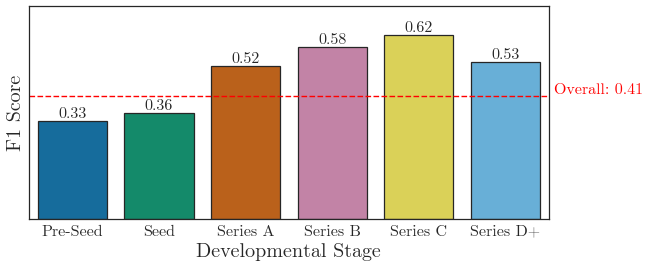

In [182]:
f = plt.figure()
ax = sns.barplot(y=results.values, x = results.index, orient="v", **outline_bars)
auto_label(ax, fmt='{:,.2f}')
add_horizontal_line(ax, overall+ 0.01, "Overall: {:,.2f}".format(overall), color="r")
ax.set_xlabel("Developmental Stage")
ax.set_ylabel("F1 Score")
plt.tight_layout()
#f.savefig(evaluation_path+"predictive_stage.pdf", bbox_inches="tight")

In [241]:
get_results(20, "evaluate")["Params"].ix[0]["steps"]

Error: Time
Error: Imputer
Error: Transformer
Error: Scaler
Error: Extractor


[('imputer',
  Imputer(axis=0, copy=True, missing_values='NaN', strategy='most_frequent',
      verbose=0)),
 ('absolute', FunctionTransformer(accept_sparse=False, func=<ufunc 'absolute'>,
            inv_kw_args=None, inverse_func=None, kw_args=None, pass_y=False,
            validate=True)),
 ('transformer', FunctionTransformer(accept_sparse=False, func=<ufunc 'sqrt'>,
            inv_kw_args=None, inverse_func=None, kw_args=None, pass_y=False,
            validate=True)),
 ('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
 ('clf', RandomForestClassifier(bootstrap=True, class_weight='balanced',
              criterion='entropy', max_depth=8, max_features='auto',
              max_leaf_nodes=None, min_impurity_split=1e-07,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=34, n_jobs=1,
              oob_score=False, random_state=None, verbose=0,
              warm_start=False))]

In [245]:
df_evaluate = get_results(20, "evaluate")

Error: Time
Error: Imputer
Error: Transformer
Error: Scaler
Error: Extractor


In [219]:
df_evaluate["feature_date_str"] = df_evaluate["feature_date"].apply(lambda x: x.year)
df_evaluate["forecast_window_years"] = df_evaluate["forecast_window"].apply(lambda x: x.days // 360).astype(str)
df_evaluate["feature_stage_single"] = df_evaluate["feature_stage"].apply(lambda x: x.value_counts().index[0])

In [220]:
hi = df_evaluate[["Y_Pred", "Y_True", "feature_stage_single","forecast_window_years","feature_date_str"]]
df = get_feature_values(hi)
results2 = feature_function(df, metrics.f1_score, group = ["feature_stage_single"])
overall2 = feature_function(df, metrics.f1_score)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


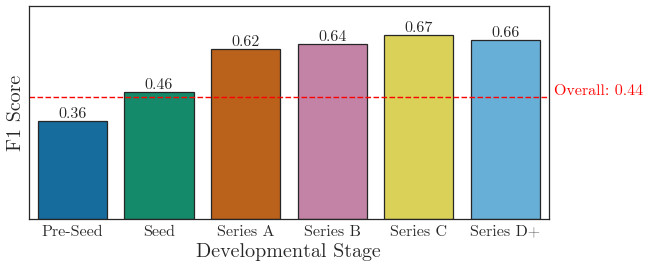

In [222]:
f = plt.figure()
ax = sns.barplot(y=results2.values, x = results2.index, orient="v", **outline_bars)
auto_label(ax, fmt='{:,.2f}')
add_horizontal_line(ax, overall2+ 0.01, "Overall: {:,.2f}".format(overall2), color="r")
ax.set_xlabel("Developmental Stage")
ax.set_ylabel("F1 Score")
plt.tight_layout()
#f.savefig(evaluation_path+"predictive_stage.pdf", bbox_inches="tight")

In [223]:
if type(results) is pd.Series: results = results.to_frame()
results["method"] = "Combined"
if type(results2) is pd.Series: results2 = results2.to_frame()
results2["method"] = "Individual"
results3 = pd.concat([results, results2], axis=0)

In [224]:
results3

,0,method
Pre-Seed,0.332,Combined
Seed,0.359,Combined
Series A,0.517,Combined
Series B,0.583,Combined
Series C,0.623,Combined
Series D+,0.532,Combined
Pre-Seed,0.357,Individual
Seed,0.463,Individual
Series A,0.622,Individual
Series B,0.640,Individual


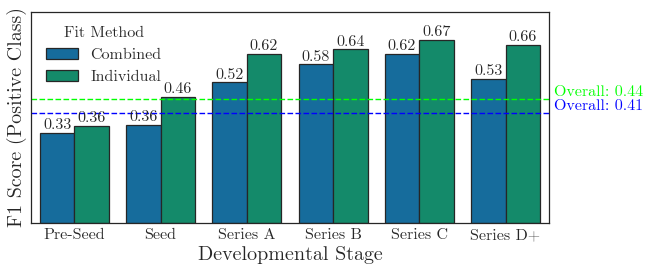

In [244]:
chart_id = "f1_individual_combined"
results3 = pd.read_pickle(evaluation_path + chart_id + ".pkl")

f = plt.figure()
ax = sns.barplot(y=results3[0], x = results3.index, hue = results3["method"], orient="v", **outline_bars)
auto_label(ax, fmt='{:,.2f}')
add_horizontal_line(ax, overall+ 0.0, "Overall: {:,.2f}".format(overall), color="blue")
add_horizontal_line(ax, overall2+ 0.02, "Overall: {:,.2f}".format(overall2), color="lime")
ax.set_xlabel("Developmental Stage")
ax.set_ylabel("F1 Score (Positive Class)")
ax.legend(title="Fit Method")
plt.tight_layout()

f.savefig(evaluation_path + chart_id + ".pdf", bbox_inches="tight")
results3.to_pickle(evaluation_path + chart_id + ".pkl")

In [133]:
df_evaluate.groupby(["feature_date_str","forecast_window_years"])["total"].describe()

feature_date_str  forecast_window_years       
2012              2                      count         1.000
                                         mean     118121.000
                                         std             NaN
                                         min      118121.000
                                         25%      118121.000
                                         50%      118121.000
                                         75%      118121.000
                                         max      118121.000
                  3                      count         1.000
                                         mean      84611.000
                                         std             NaN
                                         min       84611.000
                                         25%       84611.000
                                         50%       84611.000
                                         75%       84611.000
                                      

In [135]:
df2 = df[df["forecast_window_years"] == "2"]
cl_reports = feature_function(df2, metrics.classification_report, group = ["feature_date_str"])
for rep in cl_reports:
    print(rep)

             precision    recall  f1-score   support

          0       0.95      0.77      0.85    106583
          1       0.22      0.59      0.32     11538

avg / total       0.88      0.76      0.80    118121

             precision    recall  f1-score   support

          0       0.95      0.75      0.84    106489
          1       0.21      0.62      0.32     11535

avg / total       0.88      0.74      0.79    118024

             precision    recall  f1-score   support

          0       0.95      0.76      0.84    106583
          1       0.21      0.61      0.32     11538

avg / total       0.88      0.74      0.79    118121



In [31]:
hi = df_evaluate[["Y_Pred", "Y_True", "feature_stage","forecast_window_years", "feature_date_str"]]
output2 = get_feature_values(hi, metrics.f1_score, group = ["feature_stage","forecast_window_years"])
overall = get_feature_values(hi, metrics.f1_score)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


feature_stage  forecast_window_years
Pre-Seed       2                        0.257
               3                        0.357
               4                        0.423
Seed           2                        0.284
               3                        0.390
               4                        0.481
Series A       2                        0.429
               3                        0.553
               4                        0.615
Series B       2                        0.506
               3                        0.602
               4                        0.662
Series C       2                        0.502
               3                        0.652
               4                        0.719
Series D+      2                        0.361
               3                        0.583
               4                        0.652
dtype: float64

In [56]:
cross = pd.crosstab(values = output2.values, aggfunc=np.mean, columns = output2.index.get_level_values(level=0), index =output2.index.get_level_values(level=1))

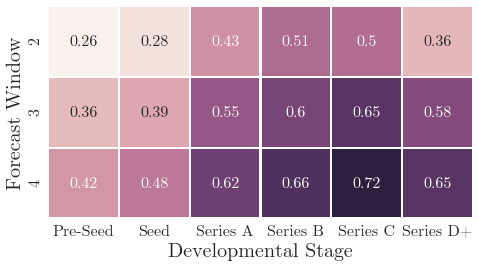

In [69]:
f = plt.figure()
ax = sns.heatmap(cross, annot=True, square=True, cbar=False, **outline_bars)
ax.set_ylabel("Forecast Window")
ax.set_xlabel("Developmental Stage")
plt.tight_layout()
f.savefig(evaluation_path+"predictive_heatmap.pdf", bbox_inches="tight")

In [100]:
df_evaluate = get_results(16, "evaluate")

Error: Time
Error: Imputer
Error: Transformer
Error: Scaler
Error: Extractor


In [101]:
df_evaluate["feature_date_str"] = df_evaluate["feature_date"].apply(lambda x: x.year)
df_evaluate["forecast_window_years"] = df_evaluate["forecast_window"].apply(lambda x: x.days // 360).astype(str)

0        Seed
1    Pre-Seed
Name: feature_stage_single, dtype: object

In [22]:
hi = df_evaluate[["feature_names", "Weights", "forecast_window_years","feature_date_str"]]
df = get_feature_values(hi, total="feature_names")

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [23]:
df["Weights"] = df["Weights"].astype(float)

In [45]:
df["feature_supergroups"] = df["feature_names"].apply(lambda x: x.split("_")[1])
df["feature_groups"] = df["feature_names"].apply(lambda x: x.split("_")[2])
df["feature_subgroups"] = df["feature_names"].apply(lambda x: "_".join(x.split("_")[2:4]))

In [315]:
yo = df.groupby(["forecast_window_years","feature_groups"]).agg({"Weights":sum})
yoo = yo.groupby(level=0, group_keys=False)
yooo = yoo.apply(lambda x: divide_groups(x, yoo.sum()))
yooo = yooo.groupby(level=0, group_keys=False)
weights = yooo.apply(lambda x: x.sort_values(by="Weights",ascending=False))["Weights"]

In [316]:
weights.values

array([ 0.42588218,  0.22633908,  0.12002801,  0.11005097,  0.05232413,
        0.04911522,  0.01177418,  0.00448624,  0.        ,  0.        ,
        0.44555856,  0.2396361 ,  0.10671208,  0.09663917,  0.05053688,
        0.04463953,  0.01079072,  0.00548696,  0.        ,  0.        ,
        0.44452473,  0.20268268,  0.14598944,  0.106741  ,  0.04668177,
        0.03904024,  0.00859172,  0.00574842,  0.        ,  0.        ])

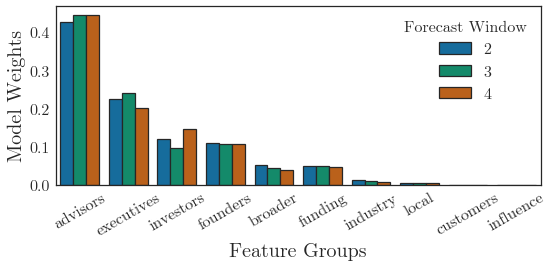

In [321]:
f = plt.figure()
ax = sns.barplot(y = weights.values, hue = weights.index.get_level_values(level=0), x=weights.index.get_level_values(level=1), orient="v", **outline_bars)
ax.set_xlabel("Feature Groups")
ax.set_ylabel("Model Weights")
plt.xticks(rotation=30)
plt.legend(title="Forecast Window")
plt.tight_layout()
f.savefig(evaluation_path+"feature_groups_window.pdf", bbox_inches="tight")

In [43]:
yo = df.groupby(["feature_date_str","feature_groups"]).agg({"Weights":sum})
yoo = yo.groupby(level=0, group_keys=False)
yooo = yoo.apply(lambda x: divide_groups(x, yoo.sum()))
yooo = yooo.groupby(level=0, group_keys=False)
weights = yooo.apply(lambda x: x.sort_values(by="Weights",ascending=False))["Weights"]

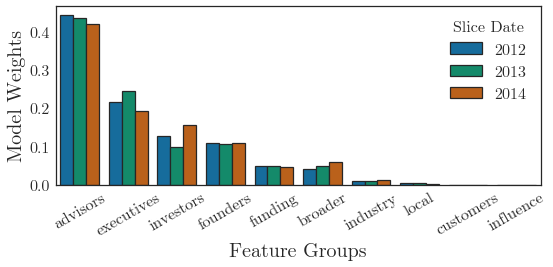

In [44]:
f = plt.figure()
ax = sns.barplot(y = weights.values, hue = weights.index.get_level_values(level=0), x=weights.index.get_level_values(level=1), orient="v", **outline_bars)
ax.set_xlabel("Feature Groups")
ax.set_ylabel("Model Weights")
plt.xticks(rotation=30)
plt.legend(title="Slice Date")
plt.tight_layout()
f.savefig(evaluation_path+"feature_groups_slice.pdf", bbox_inches="tight")

In [46]:
yo = df.groupby(["forecast_window_years","feature_supergroups"]).agg({"Weights":sum})
yoo = yo.groupby(level=0, group_keys=False)
yooo = yoo.apply(lambda x: divide_groups(x, yoo.sum()))
yooo = yooo.groupby(level=0, group_keys=False)
weights = yooo.apply(lambda x: x.sort_values(by="Weights",ascending=False))["Weights"]

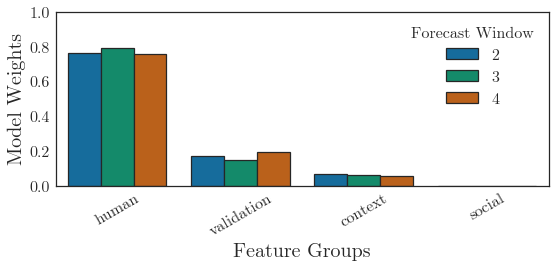

In [48]:
f = plt.figure()
ax = sns.barplot(y = weights.values, hue = weights.index.get_level_values(level=0), x=weights.index.get_level_values(level=1), orient="v", **outline_bars)
ax.set_xlabel("Feature Groups")
ax.set_ylabel("Model Weights")
ax.set_ylim(ymax=1)
plt.xticks(rotation=30)
plt.legend(title="Forecast Window")
plt.tight_layout()
#f.savefig(evaluation_path+"feature_groups_window.pdf", bbox_inches="tight")

In [228]:
df_evaluate = get_results(16, "evaluate")

Error: Time
Error: Imputer
Error: Transformer
Error: Scaler
Error: Extractor


In [229]:
df_evaluate["feature_date_str"] = df_evaluate["feature_date"].apply(lambda x: x.year)
df_evaluate["forecast_window_years"] = df_evaluate["forecast_window"].apply(lambda x: x.days // 360).astype(str)
df_evaluate["feature_stage_single"] = df_evaluate["feature_stage"].apply(lambda x: x.value_counts().index[0])

In [230]:
hi = df_evaluate[["feature_names", "Weights", "forecast_window_years","feature_date_str", "feature_stage_single"]]
df = get_feature_values(hi, total="feature_names")

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [231]:
df["Weights"] = df["Weights"].astype(float)

In [232]:
df["feature_supergroups"] = df["feature_names"].apply(lambda x: x.split("_")[1])
df["feature_groups"] = df["feature_names"].apply(lambda x: x.split("_")[2])
df["feature_subgroups"] = df["feature_names"].apply(lambda x: "_".join(x.split("_")[2:4]))

In [233]:
yo = df.groupby(["feature_stage_single","feature_groups"]).agg({"Weights":sum})
yoo = yo.groupby(level=0, group_keys=False)
yooo = yoo.apply(lambda x: divide_groups(x, yoo.sum()))
yooo = yooo.groupby(level=0, group_keys=False)
weights = yooo.apply(lambda x: x.sort_values(by="Weights",ascending=False))["Weights"]

In [234]:
order = weights.reset_index().groupby("feature_groups").agg(np.mean).sort_values(by="Weights",ascending=False).index.tolist()

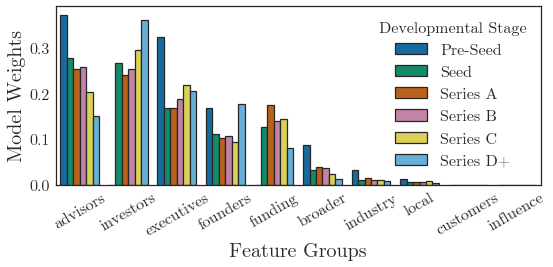

In [235]:
f = plt.figure()
ax = sns.barplot(y = weights.values, hue = weights.index.get_level_values(level=0), x=weights.index.get_level_values(level=1), order = order, orient="v", **outline_bars)
ax.set_xlabel("Feature Groups")
ax.set_ylabel("Model Weights")
plt.xticks(rotation=30)
plt.legend(title="Developmental Stage")
plt.tight_layout()
f.savefig(evaluation_path+"feature_groups_stage.pdf", bbox_inches="tight")

In [269]:
df_evaluate = get_results(16, "evaluate")

Error: Time
Error: Imputer
Error: Transformer
Error: Scaler
Error: Extractor
Error: Outcome


In [270]:
df_evaluate["feature_date_str"] = df_evaluate["feature_date"].apply(lambda x: x.year)
df_evaluate["forecast_window_years"] = df_evaluate["forecast_window"].apply(lambda x: x.days // 360).astype(str)

In [271]:
hi = df_evaluate[["feature_names", "Weights", "forecast_window_years","feature_date_str", "label_type"]]
df = get_feature_values(hi, total="feature_names")

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [272]:
df["Weights"] = df["Weights"].astype(float)

In [273]:
df["feature_supergroups"] = df["feature_names"].apply(lambda x: x.split("_")[1])
df["feature_groups"] = df["feature_names"].apply(lambda x: x.split("_")[2])
df["feature_subgroups"] = df["feature_names"].apply(lambda x: "_".join(x.split("_")[2:4]))

In [274]:
yo = df.groupby(["label_type","feature_groups"]).agg({"Weights":sum})
yoo = yo.groupby(level=0, group_keys=False)
yooo = yoo.apply(lambda x: divide_groups(x, yoo.sum()))
yooo = yooo.groupby(level=0, group_keys=False)
weights = yooo.apply(lambda x: x.sort_values(by="Weights",ascending=False))["Weights"]

In [275]:
order = weights.reset_index().groupby("feature_groups").agg(np.mean).sort_values(by="Weights",ascending=False).index.tolist()

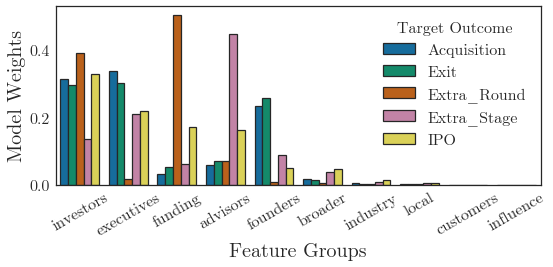

In [276]:
f = plt.figure()
ax = sns.barplot(y = weights.values, hue = weights.index.get_level_values(level=0), x=weights.index.get_level_values(level=1), order = order, orient="v", **outline_bars)
ax.set_xlabel("Feature Groups")
ax.set_ylabel("Model Weights")
plt.xticks(rotation=30)
plt.legend(title="Target Outcome")
plt.tight_layout()
f.savefig(evaluation_path+"feature_groups_outcome.pdf", bbox_inches="tight")

In [288]:
df_evaluate = get_results(16, "evaluate")

Error: Time
Error: Imputer
Error: Transformer
Error: Scaler
Error: Extractor
Error: Outcome


In [289]:
df_evaluate["feature_date_str"] = df_evaluate["feature_date"].apply(lambda x: x.year)
df_evaluate["forecast_window_years"] = df_evaluate["forecast_window"].apply(lambda x: x.days // 360).astype(str)
df_evaluate["label_type"] = df_evaluate["label_type"].apply(lambda x: x.replace("_"," "))

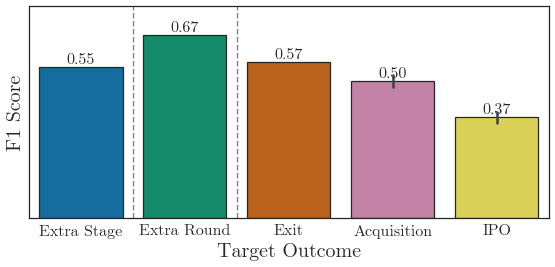

In [299]:
f= plt.figure()
order = ["Extra Stage", "Extra Round", "Exit", "Acquisition", "IPO"]
ax = sns.barplot(y = "F1", x = "label_type", data=df_evaluate, order = order, orient="v", **outline_bars)
auto_label(ax, fmt="{:.2f}")
ax.set_xlabel("Target Outcome")
ax.set_ylabel("F1 Score")
add_vertical_line(ax, 0.5, "", color="grey")
add_vertical_line(ax, 1.5, "", color="grey")
plt.tight_layout()
f.savefig(evaluation_path+"f1_predictive_outcome.pdf", bbox_inches="tight")

In [295]:
df_evaluate = get_results(16, "evaluate")

Error: Time
Error: Imputer
Error: Transformer
Error: Scaler
Error: Extractor
Error: Outcome


In [296]:
df_evaluate["feature_date_str"] = df_evaluate["feature_date"].apply(lambda x: x.year)
df_evaluate["forecast_window_years"] = df_evaluate["forecast_window"].apply(lambda x: x.days // 360).astype(str)
df_evaluate["label_type"] = df_evaluate["label_type"].apply(lambda x: x.replace("_"," "))

In [297]:
hi = df_evaluate[["Y_Pred", "Y_True", "label_type","forecast_window_years","feature_date_str"]]
df = get_feature_values(hi)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [298]:
cl_reports = feature_function(df, metrics.classification_report, group = ["label_type"])
for rep in cl_reports:
    print(rep)

             precision    recall  f1-score   support

          0       0.98      0.95      0.97    133333
          1       0.41      0.64      0.50      7102

avg / total       0.95      0.94      0.94    140435

             precision    recall  f1-score   support

          0       0.97      0.94      0.96     51706
          1       0.48      0.69      0.57      4118

avg / total       0.94      0.92      0.93     55824

             precision    recall  f1-score   support

          0       1.00      0.86      0.93     48962
          1       0.50      0.99      0.67      6862

avg / total       0.94      0.88      0.89     55824

             precision    recall  f1-score   support

          0       0.91      0.87      0.89     45739
          1       0.50      0.61      0.55     10085

avg / total       0.84      0.82      0.83     55824

             precision    recall  f1-score   support

          0       0.99      0.99      0.99    138742
          1       0.33      0.41 